In [ ]:
# Mount Google Drive (if your data is stored there; skip this if using local files)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Set the working directory (update the path based on your environment)
# If using Google Colab with Google Drive, specify the correct path; otherwise, use a local path.
os.chdir('/content/drive/MyDrive/Project_VTTI')  # Example for Google Colab
# os.chdir('/path/to/your/local/directory')  # Uncomment and replace for local usage

In [ ]:
import pandas as pd
import os  # Import necessary libraries

# Function to aggregate all CSV files from a given directory into a single DataFrame
def aggregate_csvs(directory_path):
    dataframes = []

    # Traverse the directory and subdirectories to find CSV files
    for subdir, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.csv'):
                filepath = os.path.join(subdir, file)
                df = pd.read_csv(filepath)
                dataframes.append(df)

    # Concatenate all DataFrames into one
    aggregated_df = pd.concat(dataframes, ignore_index=True)
    return aggregated_df

# Aggregate data for identified and unknown datasets
identified_data = aggregate_csvs('Identified_Classifier')  # Folder for identified (split) datasets
unknown_data = aggregate_csvs('Unknown_Classifier')        # Folder for unknown (split) datasets

# Function to extract important features from the dataset
def extract_important_features(df):
    window_steering = 10 * 1000  # 10-second window for steering features
    window_distance = 1 * 1000   # 1-second window for lane distance features

    # Steering features
    df['steering_stability'] = df['vtti.steering_wheel_position'].rolling(window=window_steering).std()

    # Pedal features
    df['brake_duration'] = df.groupby((df['vtti.pedal_brake_state'] != df['vtti.pedal_brake_state'].shift()).cumsum()).cumcount() * df['vtti.pedal_brake_state']
    df['brake_event'] = df['vtti.pedal_brake_state'].diff().apply(lambda x: 1 if x == 1 else 0)
    df['brake_frequency'] = df['brake_event'].rolling(window=window_steering).sum()

    # Lateral position features
    df['avg_abs_distance_from_center'] = df['vtti.lane_distance_off_center'].abs().rolling(window=window_distance).mean()
    df['lateral_velocity'] = df['vtti.lane_distance_off_center'].diff()
    df['lateral_acceleration'] = df['lateral_velocity'].diff()

    return df

# Apply feature extraction to both datasets
identified_data = extract_important_features(identified_data)
unknown_data = extract_important_features(unknown_data)

# Define significant columns to keep in the final analysis
significant_columns = [
    'lateral_velocity', 'brake_frequency',
    'avg_abs_distance_from_center', 'lateral_acceleration'
]

# Filter the DataFrames to include only the significant features
identified_data = identified_data[significant_columns]
unknown_data = unknown_data[significant_columns]

In [ ]:
# Check the shape of both datasets to ensure they are healthy
print("Identified Data Shape:", identified_data.shape)
print("Unknown Data Shape:", unknown_data.shape)

(2132085, 4)
(2601324, 4)


In [ ]:
# Drop rows with any missing values in both datasets
identified_data.dropna(inplace=True)
unknown_data.dropna(inplace=True)

<ipython-input-7-d42bb25b2b9c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identified_data_GBM.dropna(inplace=True) #Drop Null values
<ipython-input-7-d42bb25b2b9c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_data_GBM.dropna(inplace=True)


In [ ]:
# Check for null values in the identified dataset before proceeding
print(identified_data[['lateral_velocity', 'brake_frequency', 
                       'avg_abs_distance_from_center', 'lateral_acceleration']].isna().sum())

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
# Check for null values in the unknown dataset before proceeding
print(unknown_data[['lateral_velocity', 'brake_frequency', 
                    'avg_abs_distance_from_center', 'lateral_acceleration']].isna().sum())

lateral_velocity                0
brake_frequency                 0
avg_abs_distance_from_center    0
lateral_acceleration            0
dtype: int64


In [ ]:
# Preview the first 100 rows of the identified dataset to check for a healthy shape
print(identified_data.head(100))

       lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
15038          0.000000             58.0                    124.497663   
15039          0.000000             58.0                    124.490494   
15040          0.000000             58.0                    124.488096   
15041          0.000000             58.0                    124.485699   
15042          0.000000             58.0                    124.483301   
...                 ...              ...                           ...   
15133          0.000000             58.0                    118.997795   
15134          0.000000             58.0                    118.890905   
15135         73.443410             58.0                    118.917091   
15136         38.161072             58.0                    118.922848   
15137         -0.677319             58.0                    118.927674   

       lateral_acceleration  
15038              0.000000  
15039              0.000000  
15040              0.

In [ ]:
# Preview the first 100,000 rows of the unknown dataset to check for a healthy shape
print(unknown_data.head(100000))

        lateral_velocity  brake_frequency  avg_abs_distance_from_center  \
10433           0.000000              1.0                      8.499999   
10434           0.000000              1.0                      8.499999   
10435           0.000000              1.0                      8.499999   
10436           0.000000              1.0                      8.499999   
10437           0.000000              1.0                      8.499999   
...                  ...              ...                           ...   
294583          3.894670              0.0                     30.364727   
294584          4.233342              0.0                     30.392145   
294585         -1.550535              0.0                     30.418520   
294586          9.001236              0.0                     30.452966   
294587         11.937995              0.0                     30.500365   

        lateral_acceleration  
10433               0.000000  
10434               0.000000  
10435 

In [ ]:
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Avoid unnecessary warnings by copying the datasets
identified_data = identified_data.copy()
unknown_data = unknown_data.copy()
# Create target labels for identified (1) and unknown (0) datasets
identified_data['target'] = 1
unknown_data['target'] = 0
# Combine the datasets
combined_data = pd.concat([identified_data, unknown_data], ignore_index=True)
# Handle missing values by filling with 0
combined_data.fillna(0, inplace=True)
# Split the data into features (X) and target (y)
X = combined_data.drop('target', axis=1)
y = combined_data['target']
# Train-test split (80% training, 20% testing)
X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(X, y, test_size=0.2, random_state=42)
# Initialize the StandardScaler for feature scaling
scaler = StandardScaler()
# Fit the scaler on the training data and transform both training and test sets
X_train_gbm_scaled = scaler.fit_transform(X_train_gbm)
X_test_gbm_scaled = scaler.transform(X_test_gbm)
# Save the scaled test data and target variable using joblib
joblib.dump(X_test_gbm_scaled, 'X_test_gbm_scaled.pkl')
joblib.dump(y_test_gbm, 'y_test_gbm.pkl')

['y_test_GBM.pkl']

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the LightGBM classifier with specified hyperparameters
clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='binary_logloss',
    num_leaves=31,
    learning_rate=0.05,
    feature_fraction=0.9,
    n_estimators=1000
)
# Train the model using the scaled training data
clf.fit(X_train_gbm_scaled, y_train_gbm, eval_set=[(X_test_gbm_scaled, y_test_gbm)], verbose=0)
# Make predictions on both the training and testing data
y_pred_train_gbm = clf.predict(X_train_gbm_scaled)
y_pred_test_gbm = clf.predict(X_test_gbm_scaled)
# Evaluate the model's performance using accuracy score and classification report
print("Training Accuracy for LGBM:", accuracy_score(y_train_gbm, y_pred_train_gbm))
print("Test Accuracy for LGBM:", accuracy_score(y_test_gbm, y_pred_test_gbm))
print("\nClassification Report for LGBM Test Data:\n", classification_report(y_test_gbm, y_pred_test_gbm))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 817947, number of negative: 855530
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 1673477, number of used features: 4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488771 -> initscore=-0.044924
[LightGBM] [Info] Start training from score -0.044924
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[Ligh

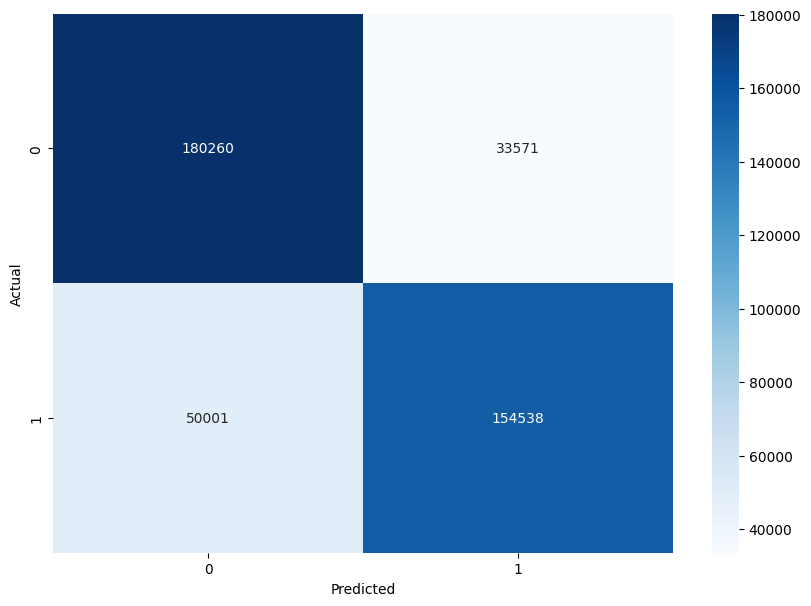

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_gbm, y_pred_test_gbm)
# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', linewidths=0.5, linecolor='black')
plt.title("Confusion Matrix for LGBM Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.show()

In [ ]:
import joblib

# Save the trained LightGBM model to a file
joblib.dump(clf, 'GBM_model.pkl')

['GBM_model.pkl']

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


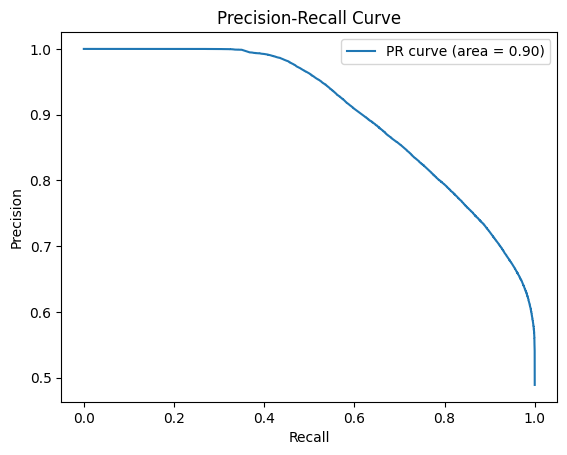

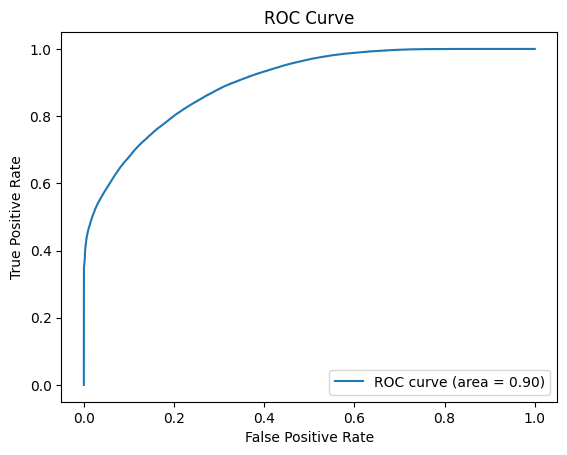

Log Loss: 0.38969978983024767
Cohen's Kappa is: 0.5995916036048805
Matthews Correlation Coefficient is: 0.6014580244719117


In [ ]:
import joblib  # No need to re-import, but useful if running this cell standalone
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score, log_loss,
    cohen_kappa_score, matthews_corrcoef
)

# Step 1: Load the saved LightGBM model
GBM_model = joblib.load('GBM_model.pkl')

# Step 2: Ensure that X_test_gbm_scaled and y_test_gbm are loaded
# Make sure you have already run the previous cells that saved these variables.

# Step 3: Generate predicted probabilities and predictions
y_prob_gbm = GBM_model.predict_proba(X_test_gbm_scaled)[:, 1]
y_pred_gbm = GBM_model.predict(X_test_gbm_scaled)

# Step 4: Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_gbm, y_prob_gbm)
average_precision = average_precision_score(y_test_gbm, y_prob_gbm)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='PR Curve (Area = %0.2f)' % average_precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

# Step 5: Plot the ROC Curve and calculate AUC
fpr_gbm, tpr_gbm, _ = roc_curve(y_test_gbm, y_prob_gbm)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_gbm, tpr_gbm, label='ROC Curve (AUC = %0.2f)' % roc_auc_gbm, color='green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()
# Step 6: Calculate Log Loss
log_loss_gbm = log_loss(y_test_gbm, y_prob_gbm)
print("Log Loss:", log_loss_gbm)
# Step 7: Calculate Cohen's Kappa Score
kappa_gbm = cohen_kappa_score(y_test_gbm, y_pred_gbm)
print("Cohen's Kappa:", kappa_gbm)
# Step 8: Calculate Matthews Correlation Coefficient (MCC)
mcc_gbm = matthews_corrcoef(y_test_gbm, y_pred_gbm)
print("Matthews Correlation Coefficient (MCC):", mcc_gbm)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'num_leaves': [31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300, 400],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0]
}

# Initialize the LightGBM classifier with base settings
clf = lgb.LGBMClassifier(
    max_depth=-1,
    random_state=314,
    n_jobs=4,
    n_estimators=5000
)

# Set up RandomizedSearchCV for hyperparameter tuning
search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=4,
    refit=True,
    random_state=314,
    verbose=2
)

# Fit the model using the scaled training data
search.fit(X_train_gbm_scaled, y_train_gbm)
# Display the best score and parameters found by RandomizedSearchCV
print(f'Best AUC score: {search.best_score_:.4f}')
print(f'Best parameters: {search.best_params_}')


Fitting 4 folds for each of 50 candidates, totalling 200 fits
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Number of positive: 613460, number of negative: 641647
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099422 seconds.
You can set `force

KeyboardInterrupt: ignored